rewrite `rf.ipynb` from laboneq into zhinst-toolkit instead.

In [1]:
%matplotlib inline
import local_broom

Added 'quench/' and 'quench/libraries' for easy importing.


In [2]:
from zhinst.toolkit import Session, CommandTable, Sequence, Waveforms, SHFQAChannelMode

import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm

import time
from monty import Monty

C:\Users\LD2007\AppData\Local\Temp\ipykernel_24132\652053071.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
experiment = {
    "desc": "Run RF measurements with toolkit."
}

monty = Monty("rf.toolkit testing", experiment)

Started new experiment rf.toolkit_testing


In [4]:
# connect to instruments

DEVICE_ID = 'DEV12158'
SERVER_HOST = 'localhost'

# connect to data server
session = Session(SERVER_HOST)

# connect to device
device = session.connect_device(DEVICE_ID)

In [115]:
session.disconnect_device(DEVICE_ID)

In [5]:
# Create channel maps for simplicity

chan = {
    "measure": device.qachannels[0],  # measure and acquire lines
    "ST": device.sgchannels[5],  # drive SET (ST) line
    "P1": device.sgchannels[5],  # drive
    "P2": device.sgchannels[5],  # drive
    "J1": device.sgchannels[5],  # drive
}

drive_chans = ["ST", "P1", "P2", "J1"]  # match keys above

In [103]:
# setup the drive outputs to rapid LF DC measurements
# WARNING: I think the order of these commands matter. Wrap in with statement to send simultaniously
with device.set_transaction():
    for c in drive_chans:
        chan[c].output.range(5)  # in dBm
        chan[c].output.rflfpath(0)  # use LF not RF (1 for RF)
    
        chan[c].output.on(1)  # enable the channel (rememeber to disable it later)

        # set the center synth frequency (oscillator frequency)
        synth = chan[c].synthesizer()
        device.synthesizers[synth].centerfreq(0)  # in Hz
    
        chan[c].awg.outputamplitude(1.0)  # overall amplitude scaling factor (don't really need to change)
        chan[c].oscs[0].freq(0)  # oscillator 1 frequency (Hz) disable for DC
        chan[c].oscs[1].freq(0)  # oscillator 2 frequency (Hz)
        chan[c].awg.modulation.enable(1)  # start digital modulation
    
        #chan[c].marker.source(0)  # setup the AWG trigger 1
        chan[c].awg.auxtriggers[0].channel(8)  # match to QA0 channel

    
    chan["measure"].output.rflfpath(0)
    chan["measure"].input.rflfpath(0)
    #chan["measure"].output.digitalmixer.centerfreq(400e6)
    chan["measure"].oscs[0].freq(406.6e6)
    chan["measure"].oscs[0].gain(1.0)
    #chan["measure"].centerfreq(0)  # in Hz (appears to be ignored when in LF mode. immutable?)
    chan["measure"].generator.auxtriggers[0].channel(8)
    chan["measure"].generator.enable(0)
    
    chan["measure"].spectroscopy.delay(220e-9) # integration delay in units of second
    chan["measure"].spectroscopy.length(1024) # integration length in units of number of samples
    chan["measure"].spectroscopy.result.averages(1) # number of averages 
    
    chan["measure"].spectroscopy.result.enable(0) # disable result logger
    chan["measure"].spectroscopy.result.length(4096)

    chan["measure"].input.range(0)
    chan["measure"].output.range(-5)
    chan["measure"].input.on(1)
    chan["measure"].output.on(1)


chan["measure"].configure_channel(
    center_frequency=0,  # in units of Hz  # minimum of 600MHz
    input_range=-10,  # in units of dBm
    output_range=-20,  # in units of dBm
    mode=SHFQAChannelMode.SPECTROSCOPY,  # SHFQAChannelMode.READOUT or SHFQAChannelMode.SPECTROSCOPY
)

chan["measure"].input.on(1)
chan["measure"].output.on(1)

chan["measure"].generator.configure_sequencer_triggering(
    aux_trigger=8,  # internal trigger
    play_pulse_delay=0,  # 0s delay between startQA trigger and the readout pulse
)

device.system.internaltrigger.repetitions(1)
device.system.internaltrigger.holdoff(100e-6)




In [ ]:
chan["measure"].output.digitalmixer.centerfreq()

In [ ]:
chan["measure"].markers(0)

In [ ]:
dir(chan["measure"].markers[0])
#dir(device.scopes[0])

## Frequency Sweep
Perform a spectroscopy sweep over the impedence network to find the resonant frequency which should be used for measurement.



In [ ]:
# laboneq version:

def res_spectroscopy(session, exp_params):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp = Experiment(
        uid="spectroscopy",
        signals=[
            ExperimentSignal(("measure"), map_to=lsg["set"]["measure_line"]),
            ExperimentSignal(("acquire"), map_to=lsg["set"]["acquire_line"]),
        ],
    )
    # define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp.acquire_loop_rt(
        uid=exp_params["exp_name"] + "_shots",
        count=2**exp_params["num_averages"],
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.CYCLIC,  # SEQUENTIAL?
    ):
        with exp.sweep(uid=exp_params["exp_name"], parameter=exp_params["freq_sweep"]):
            # readout pulse and data acquisition
            with exp.section(uid="spectroscopy"):
                # resonator signal readout
                exp.acquire(
                    signal="acquire",
                    handle=exp_params["exp_name"],
                    length=exp_params["integration_time"],
                )
            # relax time after readout - for qubit relaxation to groundstate and signal processing
            with exp.section(uid="relax", length=exp_params["wait_after_int"]):
                exp.reserve(signal="measure")
                exp.reserve(signal="acquire")
                    
    cal = Calibration()
    # sets the oscillator of the experimental measure signal
    cal["measure"] = SignalCalibration(
        local_oscillator = Oscillator(frequency = exp_params["ro_lo"]),
        oscillator=Oscillator(frequency=exp_params["freq_sweep"], modulation_type=ModulationType.HARDWARE),
        amplitude=exp_params["ro_osc_gain"],
        range = exp_params["ro_pout_range"]
    )
    cal["acquire"] = SignalCalibration(
        local_oscillator = Oscillator("ro_cent_f_acquire", frequency = exp_params["ro_lo"]),
        range = exp_params["ro_pin_range"]
    )
    exp.set_calibration(cal)

    results = compile_run(session, exp_params, exp)

    return results





start_freq = 300.0e6
stop_freq = 500.0e6
num_points = 401

freq_sweep = LinearSweepParameter(
    uid ="res_freq_set",
    start = start_freq,
    stop = stop_freq,
    count = num_points,
    axis_name="Frequency [Hz]"
)

exp_params_spec = qubit_parameters.copy()
exp_params_spec.update({
    "exp_name": "cw",
    "wait_after_int": 7e-6,
    "integration_time": 2e-6,
    "ro_osc_gain": 0.5,
    #"plot_simulation": 0,
    "num_averages": 10,
    "freq_sweep": freq_sweep,
    

    # overwrite above
    "ro_lo": 1.0e9,
    "ro_pout_range": -15,
    "ro_pin_range": -5
})

# monty.newrun("spectroscopy", exp_params_spec)
results_cw_res = res_spectroscopy(session, exp_params_spec)

f = np.transpose(np.array(results_cw_res.acquired_results[exp_params_spec["exp_name"]].axis))
data = results_cw_res.acquired_results[exp_params_spec["exp_name"]].data
monty.save({"data": data})
plot_sweeper(f, data, monty=monty)

## ST Gate 1D sweep
Measure the Coulomb peaks as ST is swept. This is probably the easiest to code initially

In [7]:
# 1.a Setup Measure pulses

seq = Sequence()
seq.code = """


repeat (100) {

    // wait for a digital trigger before starting
    waitDigTrigger(1);

    setTrigger(1);
    playZero(16000);
    setTrigger(0);

    // legacy. only useful in RF mode when we are triggering pulses. For some reason this doens't seem to work in LF mode
    // play readout waveform stored in Waveform Memory slot 1,
    // send a trigger to start integration,
    // and send a Sequencer Monitor trigger to trigger the Scope 
    //startQA(QA_GEN_0, QA_INT_0, true);
}

"""

chan["measure"].generator.load_sequencer_program(seq)

{'messages': '', 'maxelfsize': 2147483648}

In [8]:
# setup Waveform pulses

measure_pulse = np.ones(2048)

readout_pulses = Waveforms()
readout_pulses.assign_waveform(
    slot=0,
    wave1=measure_pulse,
    #wave2=measure_pulse
)

chan["measure"].generator.write_to_waveform_memory(readout_pulses)

In [ ]:
?chan["measure"].configure_channel

In [99]:
# 1.b Configure readout channel (measurement)

chan["measure"].configure_channel(
    center_frequency=0,  # in units of Hz  # minimum of 600MHz
    input_range=-10,  # in units of dBm
    output_range=-20,  # in units of dBm
    mode=SHFQAChannelMode.SPECTROSCOPY,  # SHFQAChannelMode.READOUT or SHFQAChannelMode.SPECTROSCOPY
)

chan["measure"].input.on(1)
chan["measure"].output.on(1)

chan["measure"].generator.configure_sequencer_triggering(
    aux_trigger=8,  # internal trigger
    play_pulse_delay=0,  # 0s delay between startQA trigger and the readout pulse
)

device.system.internaltrigger.repetitions(1)
device.system.internaltrigger.holdoff(100e-6)

In [ ]:
# 1.c Configure readout scope (data acquisition)
#RECORD_DURATION = 1e-6 # in units of second
#NUM_SEGMENTS = 1024
#SAMPLING_FREQUENCY = 2e9 # in units of Hz###

#device.scopes[0].configure(
#    input_select={0: "channel0_signal_input"},
#    num_samples=int(RECORD_DURATION * SAMPLING_FREQUENCY),
#    trigger_input="channel0_sequencer_monitor0", # Sequencer 1 monitor trigger
#    num_segments=NUM_SEGMENTS,
#    num_averages=1,
#    trigger_delay=214e-9, # record the data 214 ns later after receiving a trigger
#)

In [10]:
# 2.a Setup ST Drive pulses

seq = Sequence()
seq.code = """
wave w_a = ones(1024);

// Assign a single channel waveform to wave table entry 0
assignWaveIndex(1,2, w_a, 0);

 repeat(100) {
        waitDigTrigger(1);

        setTrigger(1);
        setTrigger(0);
       executeTableEntry(0);
       
    }
"""

chan["ST"].awg.load_sequencer_program(seq)

{'messages': '', 'maxelfsize': 2147483648}

In [11]:
# 2.b Setup ST drive command tables

ct_schema = chan["ST"].awg.commandtable.load_validation_schema()
ct = CommandTable(ct_schema)

gain = 1.0

ct.table[0].waveform.index = 0
ct.table[0].amplitude00.value = gain
ct.table[0].amplitude10.value = gain
ct.table[0].amplitude01.value = -gain
ct.table[0].amplitude11.value = gain
# ct.table[0].waveform.samplingRateDivider = 0  # 2^X divider
#ct.table[0].waveform.length = 10240
#ct.table[0].waveform.playHold = True

chan["ST"].awg.commandtable.upload_to_device(ct)

In [51]:
def get_results(result_node, timeout):
    wave_data_captured = {}
    wave_data_captured[result_node] = False
    start_time = time.time()
    captured_data = {}
    while not all(wave_data_captured.values()):
        if start_time + timeout < time.time():
            print(captured_data)
            raise TimeoutError('Timeout before all samples collected.')
        test = session.poll()
        for node, value in test.items():
            node = session.raw_path_to_node(node)
            for v in value:
                if node not in captured_data:
                    captured_data[node] = [v['vector']]
                else:
                    captured_data[node].append(v['vector'])
            if len(captured_data[node]) >= 1: # readout 1 point
                wave_data_captured[node] = True
                total_num_data = sum([len(element) for element in captured_data[node]])
    data = captured_data[result_node][0]
    return data

In [114]:
# 3. Run the Experiment

# chan["ST"].awg.enable_sequencer(single = 1)  # when we just need a single shot to run

result_node = chan["measure"].spectroscopy.result.data.wave
result_node.subscribe()

# Start a measurement
#device.scopes[0].run(single=True)  # start acquisition listener
chan["ST"].awg.enable(1)  # start DC driver
#chan["measure"].generator.enable_sequencer(single=True)  # start RF measurement
chan["measure"].generator.enable(1)
chan["measure"].spectroscopy.result.enable(1)  # enable result logger
device.system.internaltrigger.enable(1)  # trigger all sequencers simultaniously
chan["measure"].spectroscopy.result.enable(0)
results = get_results(result_node, 5) # get results
result_node.unsubscribe()

In [60]:
chan["ST"].awg.enable_sequencer(single = True)

In [61]:
device.system.internaltrigger.enable(1)

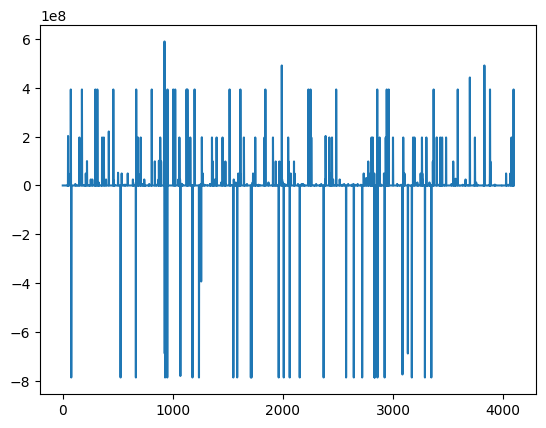

In [113]:
plt.plot(np.imag(results))

In [ ]:
# stop it
chan["measure"].generator.enable(0)

In [104]:
# 4. Get data

result_node = chan["measure"].spectroscopy.result.data.wave
result_node.subscribe()
results = get_results(result_node, 2) # get results
result_node.unsubscribe()

In [97]:
print(len(results))

1024
